# Imports

In [1]:
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from PIL import Image
import models.SANet as SANet

COCO2014_DATA_PATH = './data/coco2014/'
WIKIART_DATA_PATH = './data/wikiart/'
STYLE_PATH = './data/style'

WIKIART_STYLE_MAP = {
    'Baroque': 1,
    'Cubism': 2,
    'Early_Renaissance': 3,
    'Pointillism': 4,
    'Ukiyo_e': 5,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloaders

In [2]:
class COCO2014(Dataset):
    def __init__(self, split, max_files, transform=None):
        if split not in ['train', 'val', 'test']:
            raise ValueError(f"split must be 'train', 'val', or 'test'. Got: {split}")
        
        split = split + '2014'
        self.image_path = os.path.join(COCO2014_DATA_PATH, 'images', split)
        images = os.listdir(self.image_path)
        
        if len(images) > max_files:
            images = images[:max_files]
        
        self.images = images
        self.length = len(images)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(os.path.join(self.image_path, img_name)).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img

class StyleDataset(Dataset):
    def __init__(self, ttv, transform=None):
        self.image_path = os.path.join(STYLE_PATH, ttv)
        self.images = os.listdir(self.image_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(os.path.join(self.image_path, img_name)).convert('RGB')

        img_style = [s for s in img_name.split('_') if s[0].isupper() or (s[0] == 'e' and len(s) == 1)]
        label = WIKIART_STYLE_MAP["_".join(img_style)]

        if self.transform:
            img = self.transform(img)
            
        return img, label

In [3]:
import torchvision.transforms as transforms

val_tf = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

style_validset = StyleDataset('val', transform=val_tf)
style_validloader = DataLoader(style_validset, 64, shuffle=False)
content_validset = COCO2014('val', len(style_validset), val_tf)
content_validloader = DataLoader(content_validset, 64, shuffle=False)


# Model Evaluation Functions

## a) Quantitative

In [4]:
from skimage.metrics import structural_similarity

def compute_ssim(content_images, stylised_images):
    """Returns the average structural similarity (SSIM) between the content and stylised images"""
    ssim_sum = 0
    for content, stylised in zip(content_images, stylised_images):
        
        # Convert to numpy array
        content_img = content.detach().cpu().numpy()
        stylised_img = stylised.detach().cpu().numpy()
        
        # Convert image to grayscale
        gray_content = content_img[0, :, :]
        gray_stylised = stylised_img[0, :, :]
        
        # Compute SSIM
        score = structural_similarity(gray_content, gray_stylised, data_range=1.0)
        ssim_sum += score
    
    return ssim_sum

# Code below has been adapted from https://github.com/EndyWon/MicroAST/blob/main/metrics/calc_cs_loss.py
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def calc_content_loss(input, target):
    assert (input.size() == target.size())
    return torch.nn.MSELoss()(input, target)

def calc_style_loss(input, target):
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)
    return torch.nn.MSELoss()(input_mean, target_mean) + torch.nn.MSELoss()(input_std, target_std)

def compute_style_loss(style_images, stylised_images, net):
    """Compute the style loss between the style images and stylised images"""
    enc_1 = net[0]
    enc_2 = net[1]
    enc_3 = net[2]
    enc_4 = net[3]
    enc_5 = net[4]
    loss_s = 0.0
    output1_1 = enc_1(style_images)
    style1_1 = enc_1(stylised_images) 
    loss_s += calc_style_loss(output1_1, style1_1)
    
    output2_1 = enc_2(output1_1)
    style2_1 = enc_2(style1_1)
    loss_s += calc_style_loss(output2_1, style2_1)

    output3_1 = enc_3(output2_1)
    style3_1 = enc_3(style2_1)
    loss_s += calc_style_loss(output3_1, style3_1)

    output4_1 = enc_4(output3_1)
    style4_1 = enc_4(style3_1)
    loss_s += calc_style_loss(output4_1, style4_1)

    output5_1 = enc_5(output4_1)
    style5_1 = enc_5(style4_1)
    loss_s += calc_style_loss(output5_1, style5_1)
    
    return float(loss_s / 5)
        
def compute_content_loss(content_images, stylised_images, net):
    """Compute the content loss between the content images and stylised images"""
    enc_1 = net[0]
    enc_2 = net[1]
    enc_3 = net[2]
    enc_4 = net[3]
    enc_5 = net[4]
    
    loss_c = 0.0

    output1 = enc_4(enc_3(enc_2(enc_1(content_images))))
    content1 = enc_4(enc_3(enc_2(enc_1(stylised_images))))

    loss_c += calc_content_loss(output1, content1)
    
    output2 = enc_5(output1)
    content2 = enc_5(content1)
    
    loss_c += calc_content_loss(output2, content2)
        
    return float(loss_c / 2)

## b) Qualitative

In [5]:
from skimage import feature

def plot_results(content_images, style_images, stylised_images, nrows=5, ncols=5):
    """Plot the stylisation results"""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
    for i in range(nrows):
        content_img = content_images[i].cpu()
        style_img = style_images[i].cpu()
        stylised_img = stylised_images[i].cpu()
        
        # Plot content, style and stylised images
        axes[i][0].imshow(content_img.permute(1, 2, 0))
        axes[i][1].imshow(style_img.permute(1, 2, 0))
        axes[i][2].imshow(stylised_img.permute(1, 2, 0))
        
        # Plot canny edges of content and stylised image
        content_img = content_img.permute(1, 2, 0).numpy()[:, :, 0]
        stylised_img = stylised_img.permute(1, 2, 0).numpy()[:, :, 0]
        axes[i][3].imshow(feature.canny(content_img, sigma=1), cmap="cividis")
        axes[i][4].imshow(feature.canny(stylised_img, sigma=1), cmap="cividis")
        
        # Set subplot titles
        if i == nrows - 1:
            axes[i][0].text(0.5, -0.05, "Content", size=12, ha="center", transform=axes[i][0].transAxes)
            axes[i][1].text(0.5, -0.05, "Style", size=12, ha="center", transform=axes[i][1].transAxes)
            axes[i][2].text(0.5, -0.05, "SANet", size=12, ha="center", transform=axes[i][2].transAxes)
            axes[i][3].text(0.5, -0.05, "Content Canny Edges", size=12, ha="center", transform=axes[i][3].transAxes)
            axes[i][4].text(0.5, -0.05, "SANet Canny Edges", size=12, ha="center", transform=axes[i][4].transAxes)

    fig.suptitle('SANet Results', size=21, y=1)
    plt.tight_layout()
    plt.show()

# Load pretrained model

In [6]:
decoder = SANet.decoder
vgg = SANet.vgg
transform = SANet.Transform(in_planes=512)
decoder.load_state_dict(torch.load('./models/output/decoder_iter_500000.pth'))
vgg.load_state_dict(torch.load('./models/output/vgg_normalised.pth'))
transform.load_state_dict(torch.load('./models/output/transformer_iter_500000.pth'))

<All keys matched successfully>

# Run model evaluation

In [7]:
def SANet_eval(decoder, vgg, transform, content_loader, style_loader):
    decoder.eval()
    transform.eval()
    vgg.eval()

    enc_1 = nn.Sequential(*list(vgg.children())[:4])     # input -> relu1_1
    enc_2 = nn.Sequential(*list(vgg.children())[4:11])   # relu1_1 -> relu2_1
    enc_3 = nn.Sequential(*list(vgg.children())[11:18])  # relu2_1 -> relu3_1
    enc_4 = nn.Sequential(*list(vgg.children())[18:31])  # relu3_1 -> relu4_1
    enc_5 = nn.Sequential(*list(vgg.children())[31:44])  # relu4_1 -> relu5_1

    enc_1.to(device)
    enc_2.to(device)
    enc_3.to(device)
    enc_4.to(device)
    enc_5.to(device)
    transform.to(device)
    decoder.to(device)
    
    with torch.no_grad():
        ssim_sum = 0.0
        total_samples = 0
        running_content_loss, running_style_loss = 0.0, 0.0
        for content, style in zip(content_loader, style_loader):
            # Move content and style batches to device
            content_images = content
            content_images = content_images.to(device)
            
            style_images, style_labels = style
            style_images, style_labels = style_images.to(device), style_labels.to(device)
            
            # Create stylised images
            content4_1 = enc_4(enc_3(enc_2(enc_1(content_images))))
            content5_1 = enc_5(content4_1)

            style4_1 = enc_4(enc_3(enc_2(enc_1(style_images))))
            style5_1 = enc_5(style4_1)

            stylised_images = decoder(transform(content4_1, style4_1, content5_1, style5_1))
            stylised_images.clamp(0, 255)

            # Display qualitative evaluation metrics on first batch
            if total_samples == 0:
                plot_results(content_images, style_images, stylised_images)

            # Compute quantitative evaluation metrics
            ssim_sum += compute_ssim(content_images, stylised_images)
            running_content_loss += compute_content_loss(content_images, stylised_images, [enc_1, enc_2, enc_3, enc_4, enc_5])
            running_style_loss += compute_style_loss(style_images, stylised_images, [enc_1, enc_2, enc_3, enc_4, enc_5])
            
            total_samples += style_labels.size(0)
            
    print(f"Average SSIM = {ssim_sum / total_samples:.4f}")
    print(f"Average content loss = {running_content_loss / total_samples:.4f}")
    print(f"Average style loss = {running_style_loss / total_samples:.4f}")
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


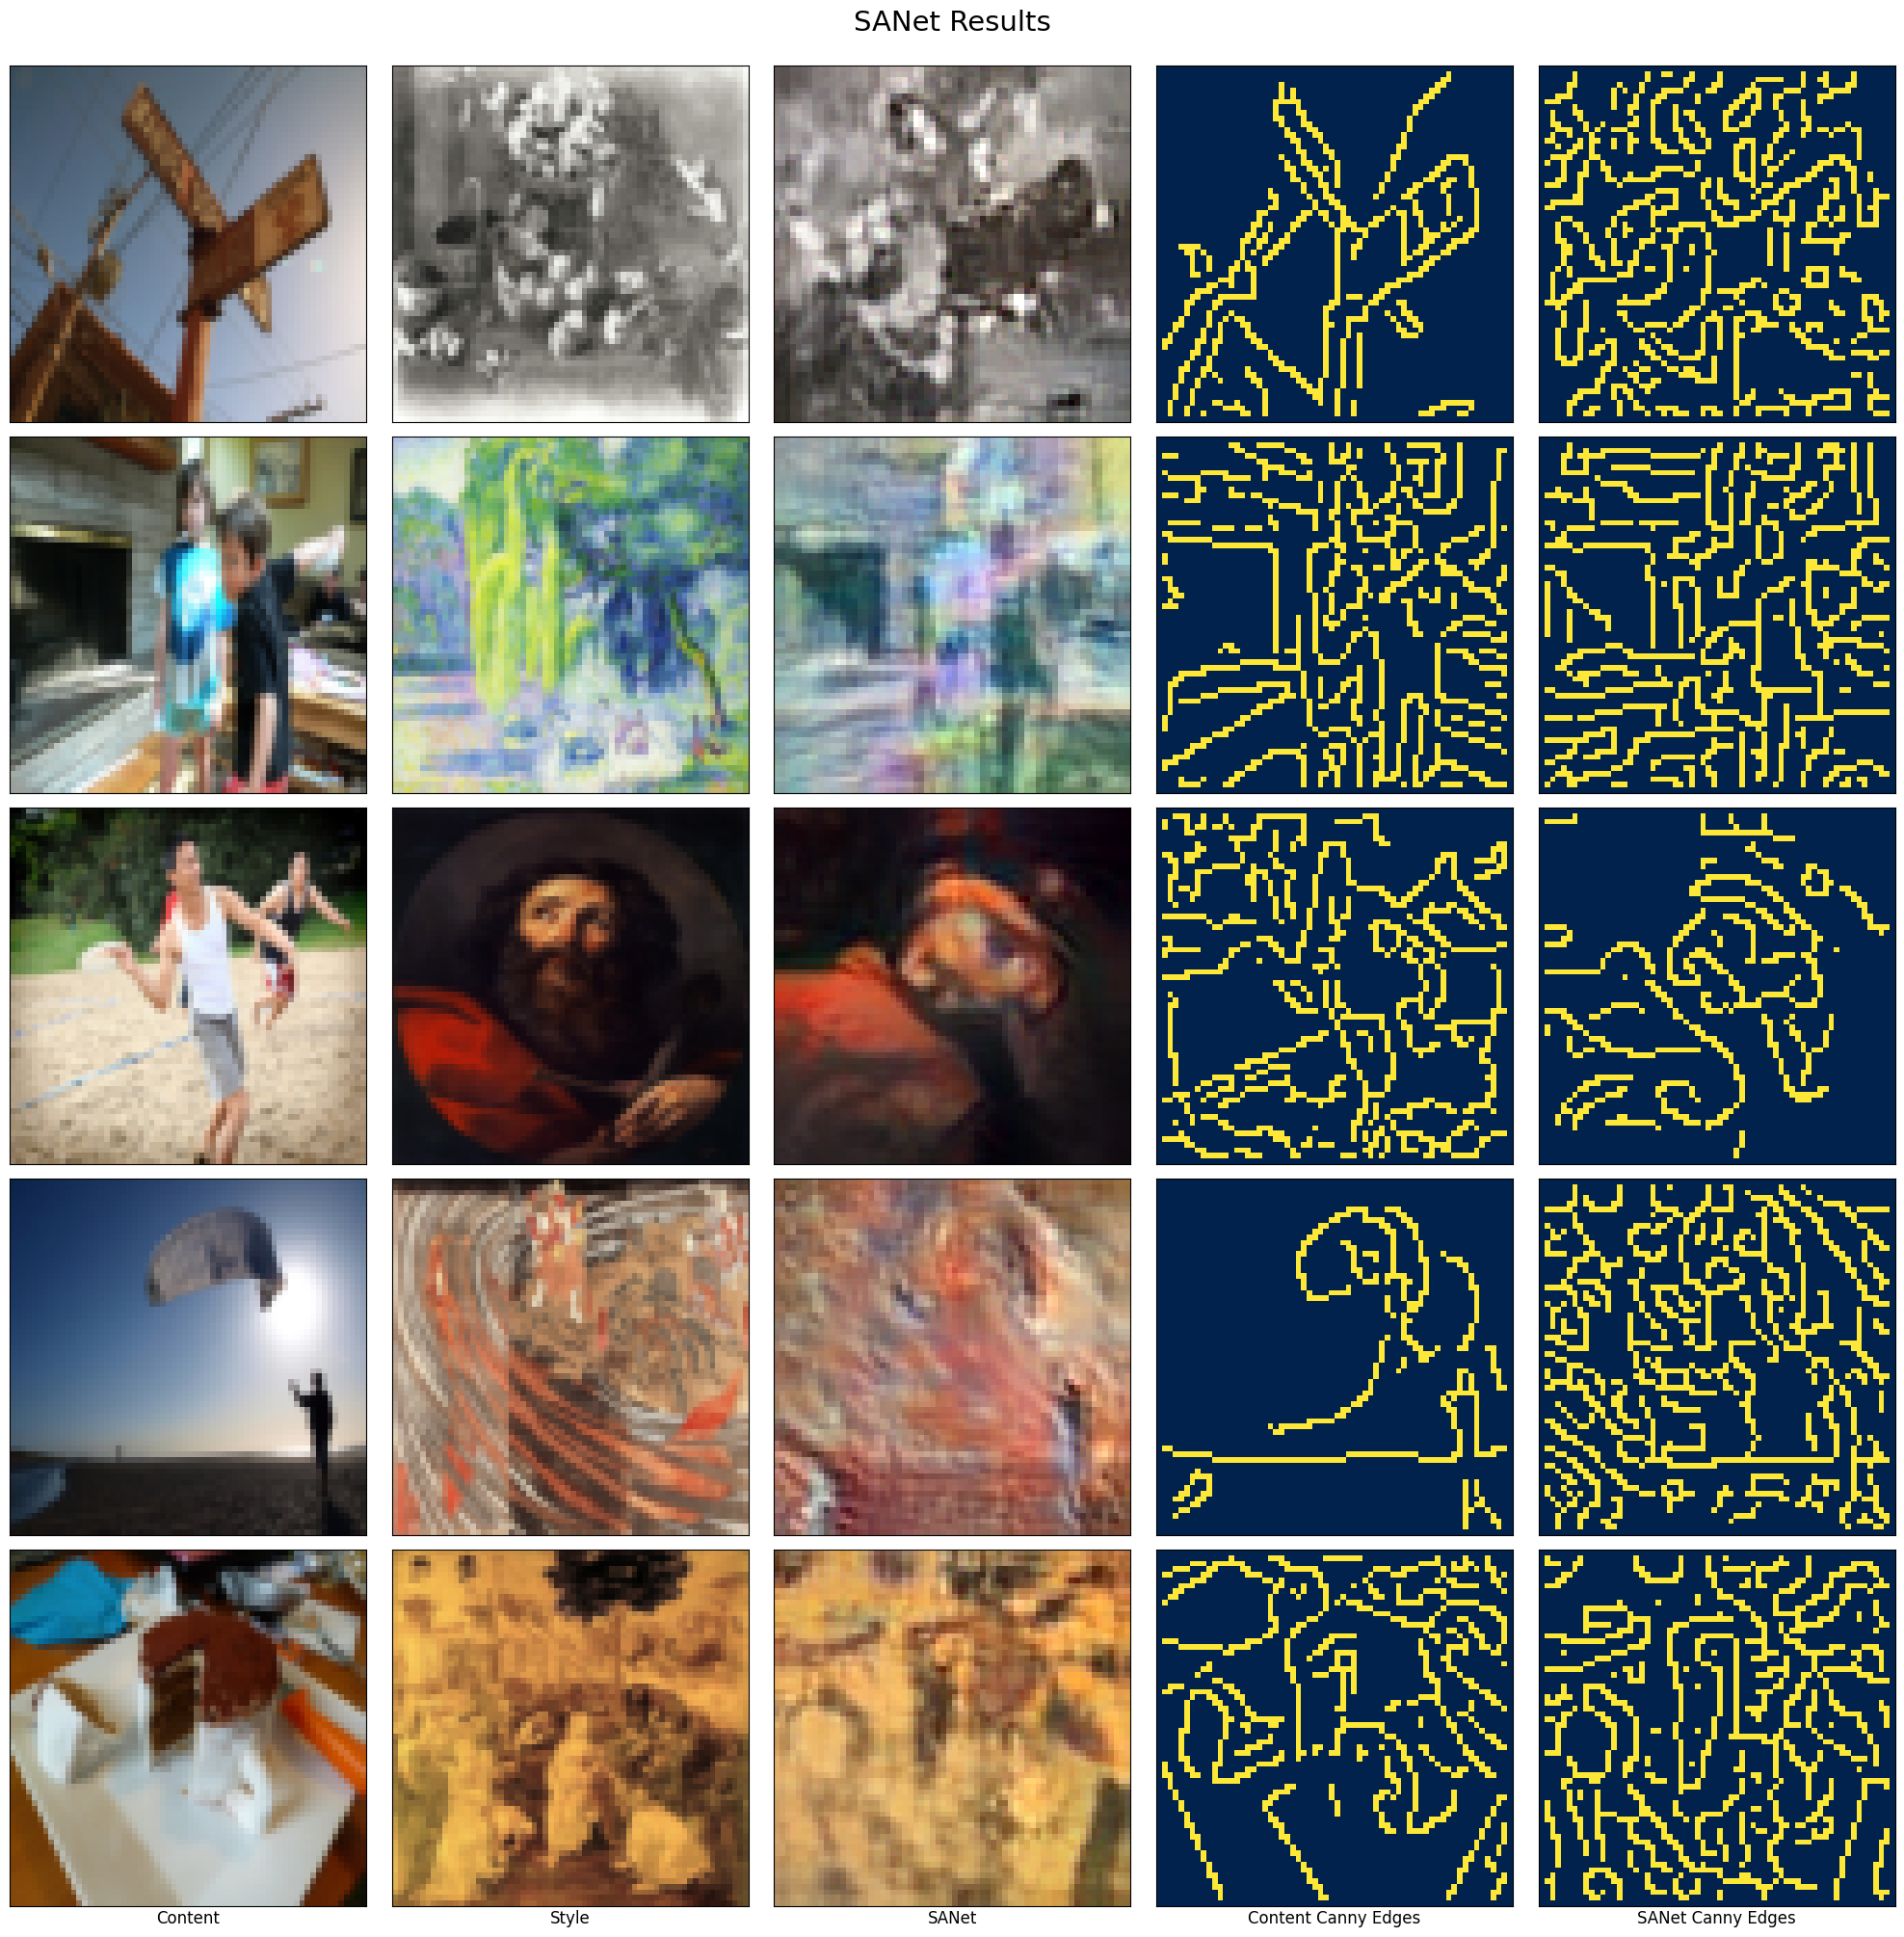

Average SSIM = 0.2384
Average content loss = 0.0823
Average style loss = 0.0152


In [8]:
SANet_eval(decoder, vgg, transform, content_validloader, style_validloader)